In [1]:
import os
import numpy as np
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid')

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install kaggle
from google.colab import files
files.upload()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bananapple","key":"8faab5776875cf07f01c3304e312ce10"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Permission Warning 방지
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d vijaykumar1799/face-mask-detection

 99% 220M/222M [00:11<00:00, 24.5MB/s]
100% 222M/222M [00:11<00:00, 20.4MB/s]


In [6]:
#압축풀기
import zipfile

local_zip = '/content/face-mask-detection.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/content/')
zip_ref.close()

# 경로설정

In [7]:
base_dir='/content/Dataset'

no_mask_dir=os.path.join(base_dir,'without_mask')
mask_dir=os.path.join(base_dir,'with_mask')
half_mask_dir=os.path.join(base_dir,'mask_weared_incorrect')

In [10]:
list1=os.listdir(no_mask_dir)
print(len(list1))
list2=os.listdir(mask_dir)
print(len(list2))
list3=os.listdir(half_mask_dir)
print(len(list3))

2994
2994
2994


# 데이터전처리

In [11]:
batch=32
img_height=250
img_width=250

In [39]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen=ImageDataGenerator(rescale=1./255,
                                 rotation_range=30,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 horizontal_flip=True,
                                 fill_mode='nearest',
                                 validation_split=0.1
                                )
train_generator=datagen.flow_from_directory(base_dir,
                                            batch_size=batch,
                                            class_mode='sparse',
                                            target_size=(img_width,img_height),
                                            subset='training'
                                            )
test_generator=datagen.flow_from_directory(base_dir,
                                           batch_size=batch,
                                           class_mode='sparse',
                                           target_size=(img_width,img_height),
                                           subset='validation'
                                           )

Found 8085 images belonging to 3 classes.
Found 897 images belonging to 3 classes.


In [40]:
#각각의 값 
print(train_generator.class_indices.items())

dict_items([('mask_weared_incorrect', 0), ('with_mask', 1), ('without_mask', 2)])


# 모델만들기

In [41]:
import tensorflow as tf

tf.__version__

from tensorflow.keras import datasets, layers, models
from keras.preprocessing import image
from keras.engine.sequential import Sequential
from tensorflow import keras
from keras import regularizers

In [37]:
kernel_s=(3,3)

model=models.Sequential()

model.add(layers.Conv2D(32,kernel_s,activation='relu',input_shape=(img_height,img_width,3),
                        kernel_regularizer=regularizers.l2(0.001),padding="VALID"))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(64, kernel_s, activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, kernel_s, activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(128,kernel_s,activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,kernel_s,activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(3,activation='softmax'))
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_60 (Conv2D)          (None, 248, 248, 32)      896       
                                                                 
 max_pooling2d_60 (MaxPoolin  (None, 124, 124, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_61 (Conv2D)          (None, 122, 122, 64)      18496     
                                                                 
 max_pooling2d_61 (MaxPoolin  (None, 61, 61, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_62 (Conv2D)          (None, 59, 59, 64)        36928     
                                                                 
 max_pooling2d_62 (MaxPoolin  (None, 29, 29, 64)     

In [38]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics='accuracy'
              )

# 학습하기

In [42]:
from tensorflow.keras.callbacks import EarlyStopping

earlystopping=EarlyStopping(monitor='val_loss', #val_loss 값이 개선되었을 때
                            patience=5 #5회 epoch 동안 val_loss가 개선되지 않는다면 종료
                            )

history=model.fit(train_generator,
                  epochs=20,
                  steps_per_epoch=100,
                  validation_data=test_generator,
                  callbacks=[earlystopping] # 설정한 epoch동안 val_loss가 개선되지 않으면 학습 종료
                  )

Epoch 1/20
100/100 [==============================] - 56s 554ms/step - loss: 0.8109 - accuracy: 0.6162 - val_loss: 0.6222 - val_accuracy: 0.7480
Epoch 2/20
100/100 [==============================] - 54s 539ms/step - loss: 0.5643 - accuracy: 0.7803 - val_loss: 0.5139 - val_accuracy: 0.8004
Epoch 3/20
100/100 [==============================] - 54s 542ms/step - loss: 0.5144 - accuracy: 0.8128 - val_loss: 0.4964 - val_accuracy: 0.8227
Epoch 4/20
100/100 [==============================] - 54s 541ms/step - loss: 0.5246 - accuracy: 0.7962 - val_loss: 0.5751 - val_accuracy: 0.8004
Epoch 5/20
100/100 [==============================] - 54s 539ms/step - loss: 0.4599 - accuracy: 0.8216 - val_loss: 0.4374 - val_accuracy: 0.8227
Epoch 6/20
100/100 [==============================] - 53s 528ms/step - loss: 0.4763 - accuracy: 0.8156 - val_loss: 0.4007 - val_accuracy: 0.8350
Epoch 7/20
100/100 [==============================] - 54s 540ms/step - loss: 0.4592 - accuracy: 0.8278 - val_loss: 0.3922 - val_ac

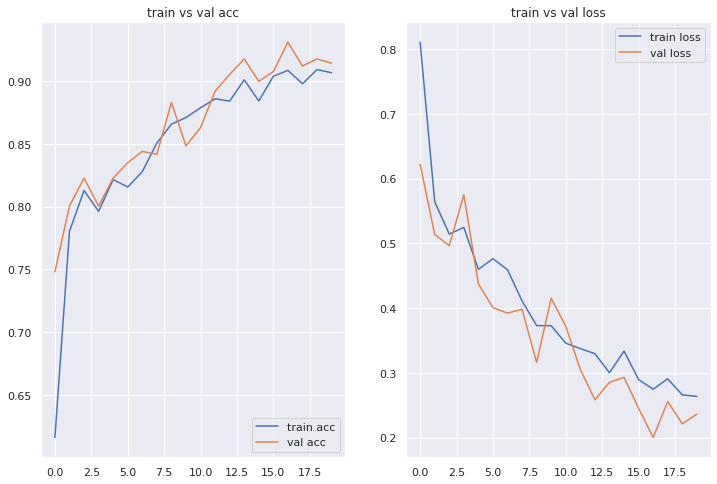

In [43]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range=range(20)

plt.figure(figsize=(12,8))

plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='train acc')
plt.plot(epochs_range, val_acc, label='val acc')
plt.legend(loc='lower right')
plt.title('train vs val acc')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='train loss')
plt.plot(epochs_range, val_loss, label='val loss')
plt.legend()
plt.title('train vs val loss')

plt.show()

In [44]:
#validation데이터 정확도 확인
test_loss, test_acc = model.evaluate(test_generator,verbose=2)#verbose는 그냥 출력문을 어떤식으로 보여줄까 묻는거 0은 출력문 안보여줌 1은 반만 2는 전체 다 출력

print('\n테스트 정확도:', test_acc)
print('\n테스트 손실값"',test_loss)

29/29 - 11s - loss: 0.2132 - accuracy: 0.9342 - 11s/epoch - 383ms/step

테스트 정확도: 0.9342252016067505

테스트 손실값" 0.21316924691200256


In [45]:
#모델 저장하기
from keras.models import load_model
model.save('마스크 착용 분류.h5')